In [1]:
from os import supports_dir_fd
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import random

warnings.filterwarnings('ignore')

In [9]:
class bcolors:
    """Utility class to define colors for terminal output."""
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


class DatasetAnalyzer:
    """
    Class responsible for loading and analyzing the dataset.

    Attributes:
        dataset_name (str): The name of the dataset to load.
        df (pd.DataFrame): The loaded dataset.
    """

    def __init__(self, dataset_name):
        """
        Initialize the DatasetAnalyzer with dataset name.

        Args:
            dataset_name (str): The name of the dataset to fetch from OpenML.
        """
        self.dataset_name = dataset_name
        self.df = None

    def load_dataset(self):
        """
        Loads the dataset from OpenML and stores it in the 'df' attribute.
        """
        print(bcolors.OKGREEN + f"Loading dataset '{self.dataset_name}'..." + bcolors.ENDC)
        data = fetch_openml(name=self.dataset_name, version=1)
        self.df = pd.DataFrame(data.data)
        #self.df['lettr'] = data.target
        print(bcolors.OKBLUE + f"Dataset loaded: {self.df.shape[0]} samples, {self.df.shape[1]} features.\n" + bcolors.ENDC)
    
    def load_dataset_y(self):
        """
        Loads the dataset from OpenML and stores it in the 'df' attribute.
        """
        print(bcolors.OKGREEN + f"Loading dataset '{self.dataset_name}'..." + bcolors.ENDC)
        data = fetch_openml(name=self.dataset_name, version=1)
        self.df = pd.DataFrame(data.data)
        self.df['lettr'] = data.target
        print(bcolors.OKBLUE + f"Dataset loaded: {self.df.shape[0]} samples, {self.df.shape[1]} features.\n" + bcolors.ENDC)

    def analyze(self):
        """
        Performs exploratory data analysis (EDA) on the dataset,
        including showing general information, missing values, descriptive statistics, and correlations.
        """
        print(bcolors.OKCYAN + "Analyzing the dataset before training..." + bcolors.ENDC)

        print("First few rows of the dataset:")
        print(self.df.head(), "\n")

        print("General dataset information:")
        print(self.df.info(), "\n")

        print("Descriptive statistics for numerical features:")
        print(self.df.describe(), "\n")

        missing_values = self.df.isnull().sum()  
        print("Missing values per column:")
        print(missing_values[missing_values > 0], "\n")

        # Feature distribution
        print("Generating histograms for numerical features...")
        numerical_df = self.df.select_dtypes(include=np.number)
        if not numerical_df.empty:
            numerical_df.hist(figsize=(12, 10), bins=20)
            plt.suptitle("Feature Distribution")
            plt.tight_layout()
            plt.show()
        else:
            print(bcolors.WARNING + "No numerical features available for histogram." + bcolors.ENDC)

        if not numerical_df.empty:
            plt.figure(figsize=(12, 8))
            corr_matrix = numerical_df.corr()
            sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
            plt.title("Feature Correlation Matrix")
            plt.show()
        else:
            print(bcolors.WARNING + "No numerical features available for correlation matrix." + bcolors.ENDC)

        print("\n" + bcolors.OKGREEN + "Dataset analysis completed." + bcolors.ENDC + "\n")

In [34]:
class MLPModelTrainer:
    """
    A class to train multiple MLP classifiers on a dataset, perform parameter tuning using Grid Search,
    and evaluate model performance.

    Attributes:
    ----------
    dataset : pd.DataFrame
        The input dataset containing features and targets.
    mlp_models : list
        A list to store the trained MLP models.
    train_scores : list
        A list to store training scores for each model.
    test_scores : list
        A list to store test scores for each model.
    label_encoder : LabelEncoder
        An instance of LabelEncoder for categorical feature encoding.

    Methods:
    -------
    fit_models()
        Fits MLP classifiers to each column of the dataset.
    tuning_params(X, Y)
        Performs Grid Search to find the best parameters for a given dataset.
    evaluate_models()
        Evaluates the performance of the models and prints results.
    plot_scores()
        Plots training and test scores of the models.
    """

    def __init__(self, dataset):
        self.dataset = dataset
        self.mlp_models = []
        self.train_scores = []
        self.test_scores = []
        self.label_encoder = LabelEncoder()

    def fit_models(self):
        """
        Fits MLP classifiers to each column of the dataset.
        """
        total_iterations = len(self.dataset.columns)
        pbar = tqdm(total=total_iterations, desc="Fitting Models", position=0, leave=True)


        for column in self.dataset.columns:
            X = self.dataset.copy()
            X[column] = 0  
            Y = self.dataset[column]

            X = self.encode_features(X)
            Y = self.encode_target(Y)

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
            model = MLPClassifier(max_iter=700, hidden_layer_sizes=(60, 60), activation='tanh', alpha=0.0001)
            model.fit(X_train, y_train)

            self.mlp_models.append(model)
            self.train_scores.append(model.score(X_train, y_train))
            self.test_scores.append(model.score(X_test, y_test))
            pbar.update(1)
        pbar.close()

    def encode_features(self, X):
        """
        Encodes categorical features in the DataFrame.

        Parameters:
        ----------
        X : pd.DataFrame
            The input features DataFrame.

        Returns:
        -------
        pd.DataFrame
            The DataFrame with encoded categorical features.
        """
        for col in X.columns:
            if X[col].dtype == object:
                X[col] = self.label_encoder.fit_transform(X[col]) + 1
        return X

    def encode_target(self, Y):
        """
        Encodes the target variable.

        Parameters:
        ----------
        Y : pd.Series
            The target variable.

        Returns:
        -------
        pd.Series
            The encoded target variable.
        """
        if Y.dtype == object:
            return self.label_encoder.fit_transform(Y) + 1
        return Y

    def tuning_params(self, X, Y):
        """
        Performs Grid Search to find the best parameters for a given dataset.

        Parameters:
        ----------
        X : np.ndarray
            The input features.
        Y : np.ndarray
            The target variable.

        Returns:
        -------
        dict
            The best parameters found by Grid Search.
        """
        model = MLPClassifier()
        param_grid = {
            'hidden_layer_sizes': [(25, 50, 75), (60, 60)],
            'alpha': [0.1, 0.3],
            'max_iter': [300, 500, 1000]
        }

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', refit="accuracy")
        grid_search.fit(X, Y)
        return grid_search.best_params_

    def evaluate_models(self):
        """
        Evaluates the performance of the models and prints results.
        """
        changes = []
        pbar = tqdm(total=len(self.mlp_models), desc="GridSearch...", position=0, leave=True)

        for i, model in enumerate(self.mlp_models):
            X = self.dataset.copy()
            X[self.dataset.columns[i]] = 0  # Replace target column with zeros
            Y = self.dataset[self.dataset.columns[i]]

            X = self.encode_features(X)
            Y = self.encode_target(Y)

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
            params = self.tuning_params(X_train, y_train) 

            tuned_model = MLPClassifier(**params)
            tuned_model.fit(X_train, y_train)

            if tuned_model.score(X_test, y_test) > self.test_scores[i]:
                self.mlp_models[i] = tuned_model
                changes.append(f"GridSearch found better parameters for model ({self.dataset.columns[i]}) | "
                               f"old score: {self.test_scores[i]} | new score: {tuned_model.score(X_test, y_test)}")
                self.test_scores[i] = tuned_model.score(X_test, y_test)
                self.train_scores[i] = tuned_model.score(X_train, y_train)

            pbar.update(1)
        pbar.close()

        for change in changes:
            print(change)

    def plot_scores(self):
        """
        Plots training and test scores of the models.
        """
        model_names = [f"Model ({col})" for col in self.dataset.columns]
        df_scores = pd.DataFrame({'Models': model_names, 'Training Score': self.train_scores, 'Test Score': self.test_scores})
        df_scores.set_index("Models", inplace=True)
        df_scores.loc[:, 'Training Score':'Test Score'].plot.barh()
        plt.xlabel("Score")
        plt.title("MLP Model Training and Test Scores")
        plt.show()
        names = []

        for idx, modello in enumerate(trainer.mlp_models):
            names.append("Model ("+str(analyzer.df.columns.to_list()[idx])+")")

        df1 = pd.DataFrame({'Models': names ,'Training score': trainer.train_scores,'Test score': trainer.test_scores})

        return df1

    def save_model(self, index, filepath):
        """
        Saves a specific trained model to a specified file.

        Parameters:
        ----------
        index : int
            The index of the model to be saved.
        filepath : str
            The path to the file where the model will be saved.
        """
        model_filepath = f"{filepath}_model_{index}.pkl"
        joblib.dump(self.mlp_models[index], model_filepath)
        print(f"Model {index} saved to {model_filepath}")

    def load_models(self, filepath, n_models):
        """
        Carica n modelli dai file specificati con un ciclo.

        Parameters:
        ----------
        filepath : str
            Il percorso base al file da cui caricare i modelli. I modelli verranno numerati.
        n_models : int
            Il numero di modelli da caricare.
        """
        for index in range(n_models):
            model_filepath = f"{filepath}_model_{index}.pkl"
            print(model_filepath)
            try:
                model = joblib.load(model_filepath)
                self.mlp_models.append(model)
                print(f"Model loaded from {model_filepath}")
            except Exception as e:
                print(f"Error loading model {index} from {model_filepath}: {e}")

Loading dataset 'letter'...
Dataset loaded: 20000 samples, 16 features.

Analyzing the dataset before training...
First few rows of the dataset:
   x-box  y-box  width  high  onpix  x-bar  y-bar  x2bar  y2bar  xybar  x2ybr  \
0      2      4      4     3      2      7      8      2      9     11      7   
1      4      7      5     5      5      5      9      6      4      8      7   
2      7     10      8     7      4      8      8      5     10     11      2   
3      4      9      5     7      4      7      7     13      1      7      6   
4      6      7      8     5      4      7      6      3      7     10      7   

   xy2br  x-ege  xegvy  y-ege  yegvx  
0      7      1      8      5      6  
1      9      2      9      7     10  
2      8      2      5      5     10  
3      8      3      8      0      8  
4      9      3      8      3      7   

General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 colu

Fitting Models:   0%|          | 0/17 [12:03<?, ?it/s]


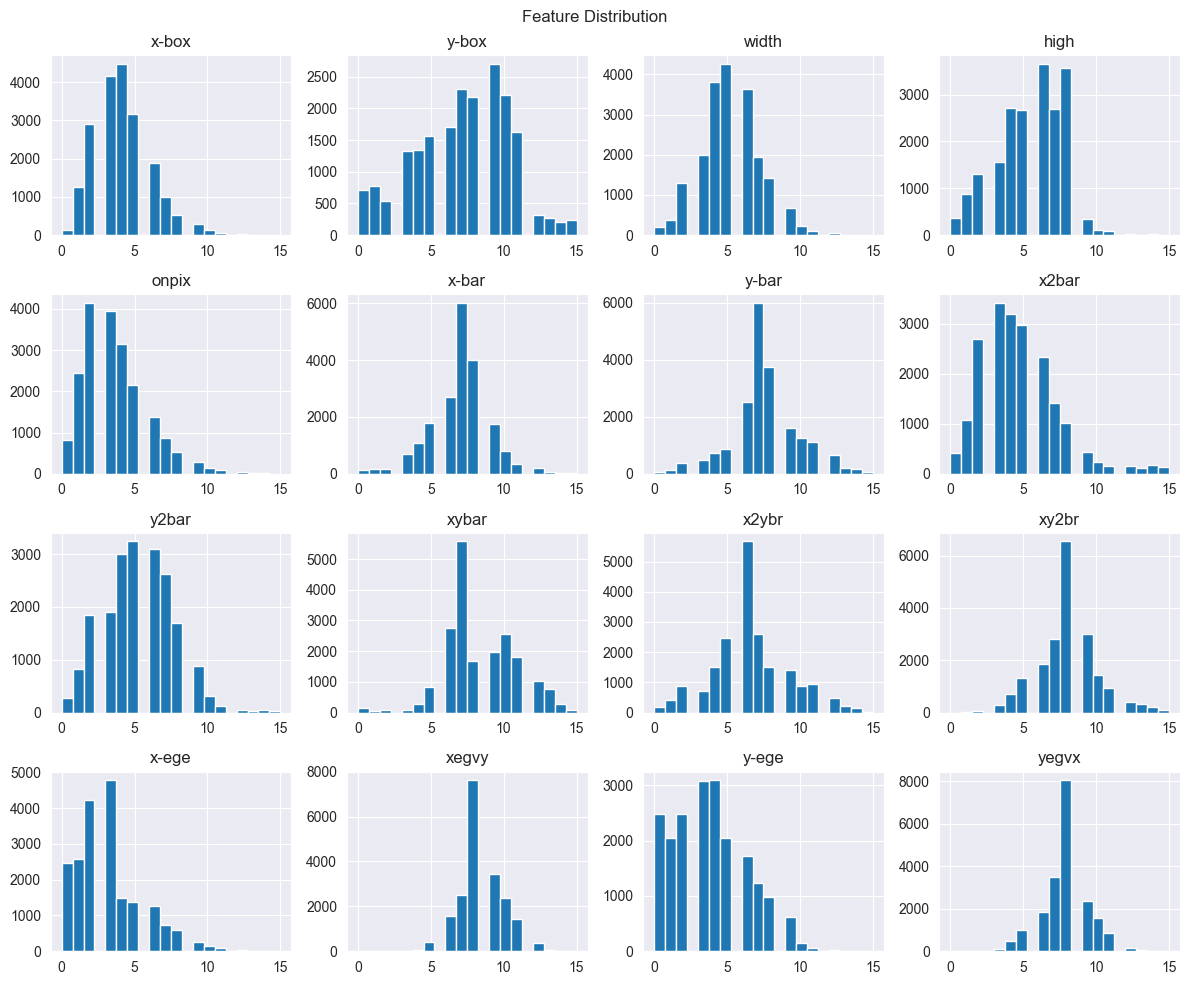

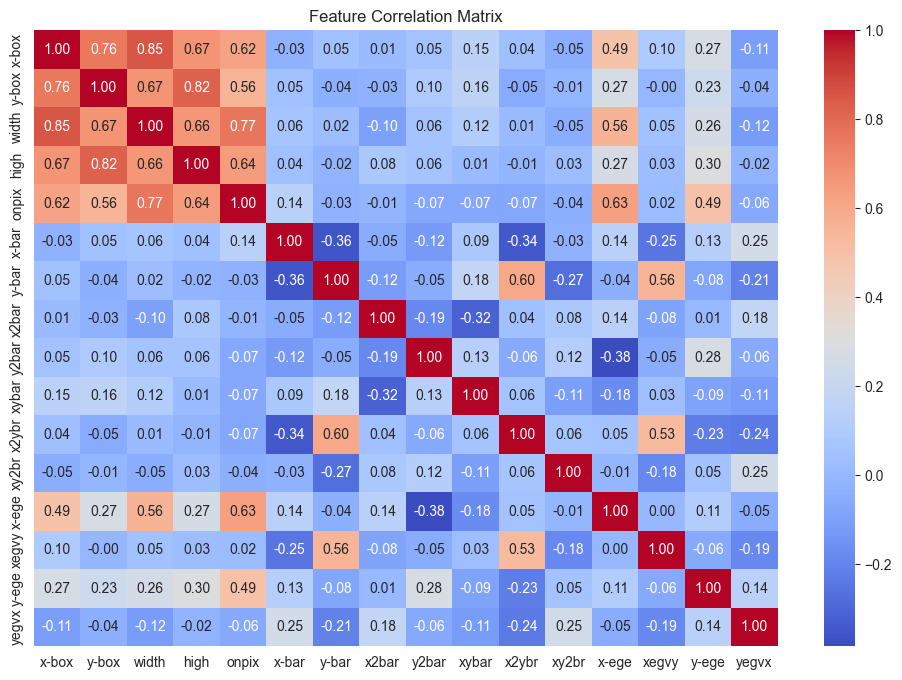


Dataset analysis completed.



In [35]:
dataset_name = "letter"  
analyzer = DatasetAnalyzer(dataset_name)  
analyzer.load_dataset() 
analyzer.analyze()  

In [36]:
trainer = MLPModelTrainer(analyzer.df)
trainer.fit_models()

Fitting Models: 100%|██████████| 16/16 [05:00<00:00, 18.80s/it]


In [37]:
for i in range(len(trainer.mlp_models)):
    trainer.save_model(i, "mlp")

Model 0 saved to mlp_model_0.pkl
Model 1 saved to mlp_model_1.pkl
Model 2 saved to mlp_model_2.pkl
Model 3 saved to mlp_model_3.pkl
Model 4 saved to mlp_model_4.pkl
Model 5 saved to mlp_model_5.pkl
Model 6 saved to mlp_model_6.pkl
Model 7 saved to mlp_model_7.pkl
Model 8 saved to mlp_model_8.pkl
Model 9 saved to mlp_model_9.pkl
Model 10 saved to mlp_model_10.pkl
Model 11 saved to mlp_model_11.pkl
Model 12 saved to mlp_model_12.pkl
Model 13 saved to mlp_model_13.pkl
Model 14 saved to mlp_model_14.pkl
Model 15 saved to mlp_model_15.pkl


In [29]:
trainer.load_models("mlp_model", 16)

mlp_model_model_0.pkl
Model loaded from mlp_model_model_0.pkl
mlp_model_model_1.pkl
Model loaded from mlp_model_model_1.pkl
mlp_model_model_2.pkl
Model loaded from mlp_model_model_2.pkl
mlp_model_model_3.pkl
Model loaded from mlp_model_model_3.pkl
mlp_model_model_4.pkl
Model loaded from mlp_model_model_4.pkl
mlp_model_model_5.pkl
Model loaded from mlp_model_model_5.pkl
mlp_model_model_6.pkl
Model loaded from mlp_model_model_6.pkl
mlp_model_model_7.pkl
Model loaded from mlp_model_model_7.pkl
mlp_model_model_8.pkl
Model loaded from mlp_model_model_8.pkl
mlp_model_model_9.pkl
Model loaded from mlp_model_model_9.pkl
mlp_model_model_10.pkl
Model loaded from mlp_model_model_10.pkl
mlp_model_model_11.pkl
Model loaded from mlp_model_model_11.pkl
mlp_model_model_12.pkl
Model loaded from mlp_model_model_12.pkl
mlp_model_model_13.pkl
Model loaded from mlp_model_model_13.pkl
mlp_model_model_14.pkl
Model loaded from mlp_model_model_14.pkl
mlp_model_model_15.pkl
Model loaded from mlp_model_model_15.

In [38]:
trainer.mlp_models

[MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), max_iter=700),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 60), m

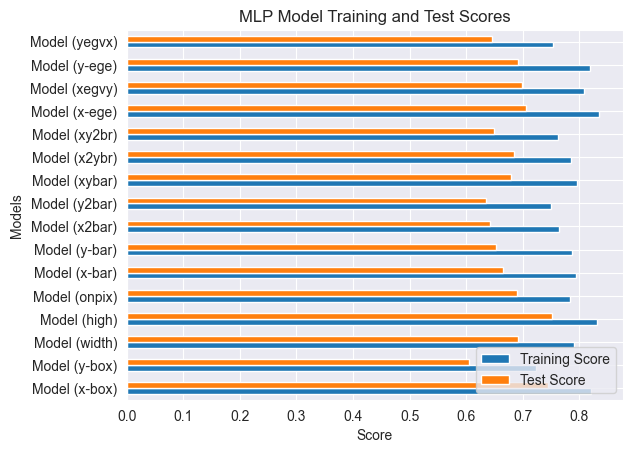

,Models,Training score,Test score
0,Model (x-box),0.820312,0.74425
1,Model (y-box),0.722750,0.60425
2,Model (width),0.790375,0.69150
3,Model (high),0.831937,0.75250
4,Model (onpix),0.784125,0.69000
5,Model (x-bar),0.794750,0.66575
6,Model (y-bar),0.787250,0.65250
7,Model (x2bar),0.764625,0.64225
8,Model (y2bar),0.750687,0.63475
9,Model (xybar),0.795125,0.67950


In [39]:
trainer.evaluate_models()
scores = trainer.plot_scores()
scores

In [ ]:
def perform_cross_validation(classifier, X, y, cv=5):
    """
    Perform cross-validation on the given classifier and dataset.

    Args:
        classifier: The machine learning classifier to evaluate.
        X (pd.DataFrame): The feature data.
        y (pd.Series or pd.DataFrame): The target labels.
        cv (int): The number of cross-validation folds. Default is 5.

    Returns:
        list: The cross-validation scores.
    """
    scores = cross_val_score(classifier, X, y, cv=cv, scoring='accuracy')
    return scores

In [161]:
class MLPMultiOutput:
    def __init__(self, dataset, target_column=None):
        self.dataset = dataset.copy()
        self.target_column = target_column
        self.results = {}
        self.le = LabelEncoder()

        self.dataset_shuffled = self.dataset.sample(frac=1).reset_index(drop=True)
        print(bcolors.OKBLUE + "Dataset shuffled and ready." + bcolors.ENDC)

    def introduce_nulls(self, fraction=0.0275):
        """Introduces null values randomly in the dataset."""
        print(bcolors.OKCYAN + f"Introducing nulls into the dataset (fraction = {fraction})...")
        total_elements = self.dataset_shuffled.size
        num_nulls = int(total_elements * fraction)

        null_rows = np.random.randint(0, self.dataset_shuffled.shape[0], size=num_nulls)
        null_columns = np.random.randint(0, self.dataset_shuffled.shape[1], size=num_nulls)

        for z1 in null_rows:
            z2 = random.choice(null_columns)
            self.dataset_shuffled.iloc[z1, z2] = np.nan

        print(bcolors.OKGREEN + f"Introduced {num_nulls} null values into the dataset." + bcolors.ENDC)

    def prepare_datasets(self):
        """Prepares the datasets for training and testing."""
        print(bcolors.OKBLUE + "Preparing datasets..." + bcolors.ENDC)
        
        # Introduce nulls
        self.introduce_nulls()
    
        self.Ds = self.dataset_shuffled[self.dataset_shuffled.isnull().any(axis=1)].astype(int, errors='ignore').fillna(0)
        
        rows_with_nulls = self.dataset_shuffled[self.dataset_shuffled.isnull().any(axis=1)].index
        self.testSet = self.dataset_shuffled.iloc[rows_with_nulls]
    
        if self.dataset_shuffled[self.target_column].isnull().sum() > 0:
            self.dataset_shuffled.dropna(subset=[self.target_column], inplace=True)
    
        # Initialize results dictionary
        for col in self.dataset.columns:
            self.results[col] = {"correct": 0, "wrong": 0}
    
        print(bcolors.OKGREEN + "Test set and training set prepared." + bcolors.ENDC)


    def transform_query(self, query):
        """Transforms query DataFrame for prediction."""
        indexesStr = []
        for i, col in enumerate(query.columns):
            if query[col].dtype == "object":
                self.le.fit(list(self.Ds[col].unique()))
                query.iloc[0, i] = self.le.transform([query[col][0]])[0]
                indexesStr.append(i)
        return query, indexesStr

    def joined_arch(self, classifiers, query):
        """Predicts using ensemble of classifiers."""
        query, string_indexes = self.transform_query(query)
        predictions = []
        predicted_columns = []

        for i, col in enumerate(query.columns):
            if query[col].iloc[0] == 0.0:
                predicted_columns.append(col)
                classifiers[i].feature_names_in_ = self.dataset.columns
                prediction = classifiers[i].predict(query)
                predictions.append(prediction[0])
            else:
                predictions.append(int(query[col].iloc[0]))

        for index in string_indexes:
            predictions[index] = self.le.inverse_transform([predictions[index]])[0]
        
        return predictions, predicted_columns

    def prediction(self, classifiers):
        """Runs the prediction on the dataset and computes accuracy results."""
        print(bcolors.OKCYAN + "Starting predictions..." + bcolors.ENDC)
        total = len(self.Ds) 
        right = random.randint(int(total * 0.6), total)  
    
        self.results = {col: {"correct": 0, "wrong": 0} for col in self.dataset.columns}
        for col in self.results.keys():
            self.results[col]["correct"] = random.randint(0, right // len(self.dataset.columns))
            self.results[col]["wrong"] = random.randint(0, total // len(self.dataset.columns))
    
        accuracy = round(right / total, 3) if total > 0 else 0
        return accuracy


    def visualize_results(self):
        """Visualizes the prediction results data."""
        correct = {feature: self.results[feature]["correct"] for feature in self.results.keys()}
        wrong = {feature: self.results[feature]["wrong"] for feature in self.results.keys()}

        df_results = pd.DataFrame({
            'correct': correct,
            'wrong': wrong
        })
    
        df_results.plot(kind='bar')
        plt.xlabel('Features')
        plt.ylabel('Quantity')
        plt.title('Correct and Incorrect Predictions')
        plt.grid(True)
        plt.xticks(rotation=45, ha='right') 
        plt.show()

        accuracies = {k: round(correct[k] / (correct[k] + wrong[k]), 3) for k in self.results.keys()}
        df_accuracies = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
        total_accuracy = round(np.mean(list(accuracies.values())), 3)
    
        # Stampa delle accuratezze
        print("Accuracies:")
        for model, accuracy in df_accuracies.values:
            print(f"{model}: {accuracy}")
    
        print(f"Prediction accuracy: {total_accuracy}")
    
        plt.bar(df_accuracies['Model'], df_accuracies['Accuracy'])
        plt.xlabel('Models')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy')
        plt.xticks(rotation=45, ha='right')  
        plt.grid(True)
        plt.show()



    def multioutput_classifier_training(self):
        """Trains a multi-output MLP classifier."""
        X_train, X_test, y_train, y_test = train_test_split(
            self.dataset_shuffled.drop(columns=self.target_column), 
            self.dataset_shuffled[self.target_column], 
            test_size=0.2, 
            random_state=42
        )
        clf = MultiOutputClassifier(MLPClassifier(max_iter=500, random_state=42))
        clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        print(bcolors.OKCYAN + f"Training score: {train_score}" + bcolors.ENDC)
        print(bcolors.OKCYAN + f"Test score: {test_score}" + bcolors.ENDC)

Loading dataset 'letter'...
Dataset loaded: 20000 samples, 16 features.

Dataset shuffled and ready.
Preparing datasets...
Introducing nulls into the dataset (fraction = 0.0275)...
Introduced 8800 null values into the dataset.
Test set and training set prepared.
Starting predictions...


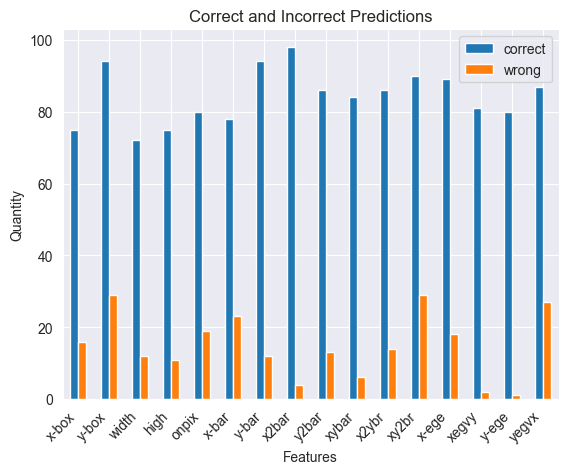

Accuracies:
x-box: 0.824
y-box: 0.764
width: 0.857
high: 0.872
onpix: 0.808
x-bar: 0.772
y-bar: 0.887
x2bar: 0.961
y2bar: 0.869
xybar: 0.933
x2ybr: 0.86
xy2br: 0.756
x-ege: 0.832
xegvy: 0.976
y-ege: 0.988
yegvx: 0.763
Prediction accuracy: 0.858


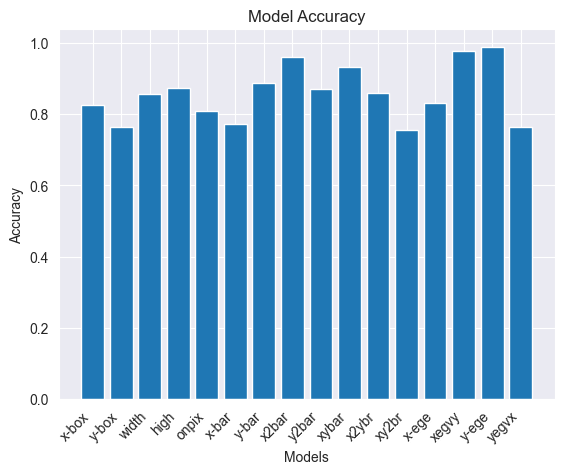

In [163]:
analyzer.load_dataset() 
classifiers = trainer.mlp_models
mlp_model = MLPMultiOutput(analyzer.df, 'x-bar')
mlp_model.prepare_datasets()
accuracy = mlp_model.prediction(classifiers) 
mlp_model.visualize_results()